In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os


In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.datasets import ImageFolder,DatasetFolder

In [3]:
data_dir='/kaggle/input/animefacedataset/'

In [4]:
# def open_image(path):
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')

In [5]:
# class catsDataset(Dataset):
#     def __init__(self,root,transform):
#         super().__init__()
#         self.root=root
#         self.files=[fname for fname in os.listdir(root) if fname.endswith('.jpg')]
#         self.transform=transform

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self,i):
#         fname=self.files[i]
#         fpath=os.path.join(self.root,fname)
#         img=self.transform(open_image(fpath))
#         return img

In [6]:
# for image in dataset:
#     print(image.shape)
#     plt.imshow(image.permute(1,2,0))
#     break
    
    

In [7]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [8]:
print(os.listdir(data_dir+'/images')[:10])


['35715_2011.jpg', '48610_2014.jpg', '34719_2011.jpg', '40266_2012.jpg', '4199_2002.jpg', '40739_2013.jpg', '42515_2013.jpg', '52482_2015.jpg', '46555_2014.jpg', '11579_2005.jpg']


In [9]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [10]:
def denorm(img_tensors):
    return img_tensors*stats[1][0] + stats[0][0]

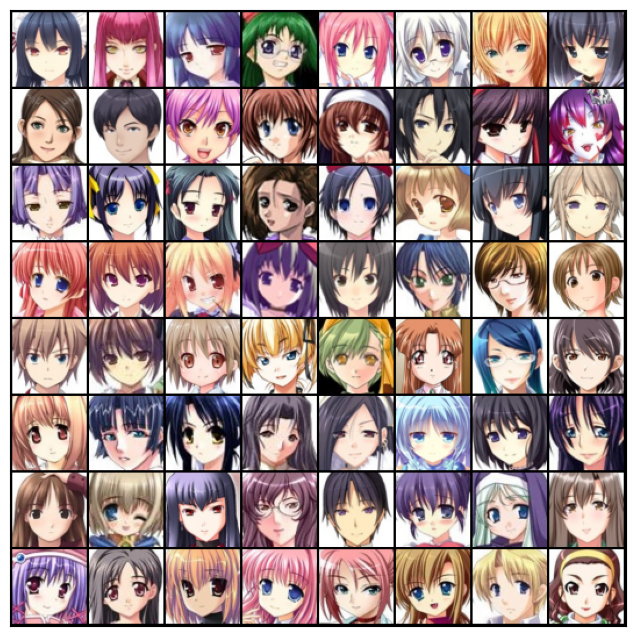

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [13]:
device=get_default_device()
device

device(type='cuda')

In [14]:
train_dl=DeviceDataLoader(train_dl,device)

In [15]:
discriminator=nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),

    nn.Flatten(),
    nn.Sigmoid()

    
)

In [16]:
discriminator=to_device(discriminator,device)

In [17]:
latent_size=128

generator=nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,
                          stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512,256,kernel_size=4,
                          stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,
                          stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,
                          stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    
)

In [42]:
# generator=nn.Sequential(
#     nn.ConvTranspose2d(latent_size,512,kernel_size=4,
#                           stride=1,padding=0,bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#         nn.ConvTranspose2d(512,256,kernel_size=4,
#                           stride=1,padding=0,bias=False),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),

#     nn.ConvTranspose2d(256,128,kernel_size=4,
#                           stride=1,padding=0,bias=False),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
# )
# xb=torch.randn(batch_size,latent_size,1,1)

# fake_images=generator(xb)
# print(fake_images.shape)
# # show_images(fake_images)

torch.Size([128, 128, 10, 10])


torch.Size([128, 3, 64, 64])


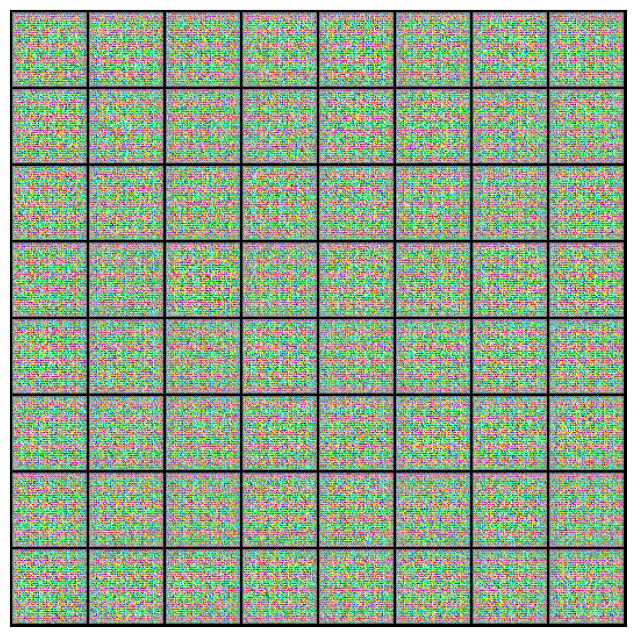

In [18]:
xb=torch.randn(batch_size,latent_size,1,1)

fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator=to_device(generator,device)

In [20]:
def train_discriminator(real_image,opt_d):
    opt_d.zero_grad()

    real_pred=discriminator(real_image)
    real_target=torch.ones(real_image.size(0),1,device=device)
    real_loss=F.binary_cross_entropy(real_pred,real_target)
    real_score=torch.mean(real_pred).item()

    latent=torch.randn(batch_size,latent_size,1,1,device=device)


    fake_image=generator(latent)
    fake_target=torch.zeros(fake_image.size(0),1,device=device)
    fake_pred=discriminator(fake_image)
    fake_loss=F.binary_cross_entropy(fake_pred,fake_target)
    fake_score=torch.mean(fake_pred).item()

    loss=real_loss+fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(),real_score,fake_score


In [21]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent=torch.randn(batch_size,latent_size,1,1,device=device)
    fake_image=generator(latent)

    preds=discriminator(fake_image)
    target=torch.ones(batch_size,1,device=device)
    loss=F.binary_cross_entropy(preds,target)

    loss.backward()
    opt_g.step()

    return loss.item()


In [22]:
from torchvision.utils import save_image

sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [23]:
def save_sample(index,latent_tensors,show=True):
    fake_images=generator(latent_tensors)
    fake_fname='generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
    print('Saving' ,fake_fname)
    if show:
        fig,ax=plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

Saving generated-images-0000.png


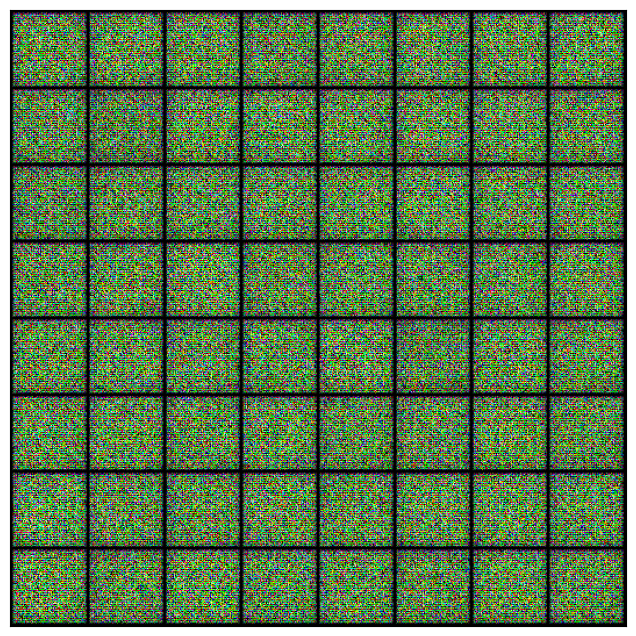

In [24]:
fixed_latent=torch.randn(64,latent_size,1,1,device=device)
save_sample(0,fixed_latent)

In [25]:
lr=0.0002
epoch=25

In [26]:
from tqdm.notebook import tqdm

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        save_sample(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [27]:
history=fit(epoch,lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 5.3947, loss_d: 0.6623, real_score: 0.8567, fake_score: 0.3622
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 6.9983, loss_d: 0.6052, real_score: 0.8949, fake_score: 0.3580
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.2936, loss_d: 0.3647, real_score: 0.7895, fake_score: 0.0790
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 5.2628, loss_d: 0.1966, real_score: 0.8741, fake_score: 0.0348
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 12.0935, loss_d: 0.7278, real_score: 0.9766, fake_score: 0.4330
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 11.8370, loss_d: 0.3965, real_score: 0.9982, fake_score: 0.2756
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 11.0929, loss_d: 0.0851, real_score: 0.9292, fake_score: 0.0010
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 6.0861, loss_d: 0.1178, real_score: 0.9424, fake_score: 0.0485
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 15.7142, loss_d: 0.4156, real_score: 0.9920, fake_score: 0.2849
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 16.5825, loss_d: 0.3973, real_score: 0.9930, fake_score: 0.2301
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 9.8140, loss_d: 0.2041, real_score: 0.8511, fake_score: 0.0002
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 13.4529, loss_d: 0.1837, real_score: 0.8626, fake_score: 0.0000
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 5.2920, loss_d: 0.0536, real_score: 0.9749, fake_score: 0.0223
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 7.7876, loss_d: 0.1125, real_score: 0.9587, fake_score: 0.0592
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 13.1225, loss_d: 0.3789, real_score: 0.7627, fake_score: 0.0000
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.6323, loss_d: 0.1178, real_score: 0.9433, fake_score: 0.0373
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 10.6294, loss_d: 0.0736, real_score: 0.9690, fake_score: 0.0304
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 10.0280, loss_d: 0.1872, real_score: 0.9431, fake_score: 0.0955
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 6.2863, loss_d: 0.0672, real_score: 0.9764, fake_score: 0.0377
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 8.2935, loss_d: 0.0126, real_score: 0.9973, fake_score: 0.0095
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 5.7558, loss_d: 0.0466, real_score: 0.9730, fake_score: 0.0055
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.2607, loss_d: 0.3772, real_score: 0.7926, fake_score: 0.0011
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 8.0553, loss_d: 0.0488, real_score: 0.9619, fake_score: 0.0053
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.0374, loss_d: 0.0691, real_score: 0.9758, fake_score: 0.0416
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 16.2510, loss_d: 0.0569, real_score: 0.9843, fake_score: 0.0293
Saving generated-images-0025.png


In [28]:
losses_g,losses_d,real_scores,fake_scores=history

In [29]:
torch.save(generator.state_dict(),'G.pth')
torch.save(discriminator.state_dict(),'D.pth')

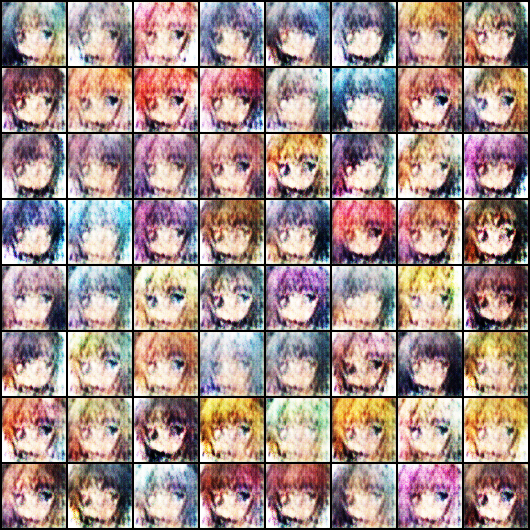

In [30]:
from IPython.display import Image
Image('./generated/generated-images-0001.png')

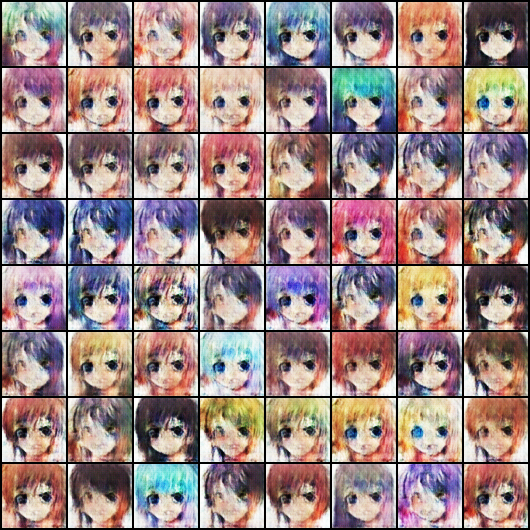

In [31]:
Image('./generated/generated-images-0010.png')

In [32]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


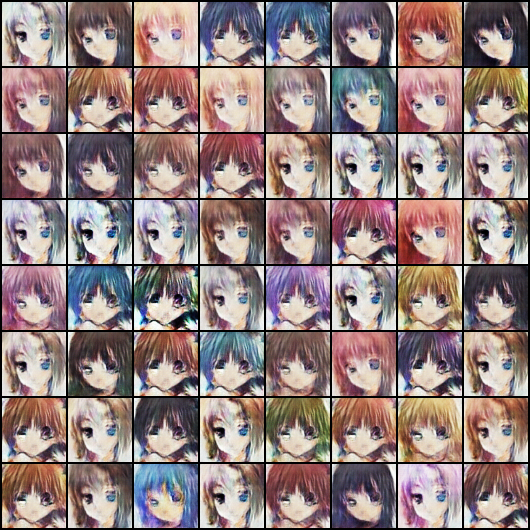

In [44]:
Image('./generated/generated-images-0025.png')